# Imports

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import string

# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

#import nltk
#nltk.download('stopwords')

In [2]:
tweets_text_label = pd.read_json('../data/MMHS150K_GT.json', orient='index', convert_axes=False, convert_dates=False, keep_default_dates=False) #
tweets_text_label = tweets_text_label.drop(columns=['img_url', 'tweet_url'])
tweets_text_label.head(5)

,labels,tweet_text,labels_str
1114679353714016256,"[4, 1, 3]",@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[Religion, Racist, Homophobe]"
1063020048816660480,"[5, 5, 5]",My horses are retarded https://t.co/HYhqc6d5WN,"[OtherHate, OtherHate, OtherHate]"
1108927368075374593,"[0, 0, 0]",“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[NotHate, NotHate, NotHate]"
1114558534635618305,"[1, 0, 0]",RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[Racist, NotHate, NotHate]"
1035252480215592966,"[1, 0, 1]",“EVERYbody calling you Nigger now!” https://t....,"[Racist, NotHate, Racist]"


# Multimodal Hate Speech

# Size

In [3]:
print(f'For the training we have {len(tweets_text_label)} unique annotated tweets with text and image data. Taking up over 6GB of Disk Space')

For the training we have 149823 unique annotated tweets with text and image data. Taking up over 6GB of Disk Space


## Label Distribution
The dataset distinguishes between 0 - NotHate, 1 - Racist, 2 - Sexist, 3 - Homophobe, 4 - Religion, 5 - OtherHate for our purpose we shrink it to 0 - NotHate, 1 - Hate. <br>
Each tweet in the dataset was annotated by 3 different Annotators. Therefore we follow the majority of Voters.

In [4]:
dct = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1}
tweets_text_label['labels'] = tweets_text_label['labels'].apply(lambda x: [*map(dct.get, x)])

In [5]:
tweets_text_label['majority_label'] = tweets_text_label.apply(lambda x: Counter(x['labels']).most_common()[0][0], axis=1)

<AxesSubplot:>

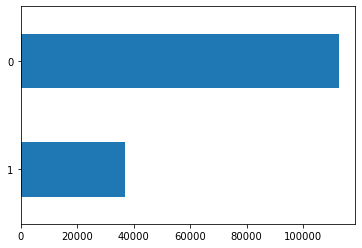

In [6]:
tweets_text_label['majority_label'].value_counts().sort_values().plot(kind = 'barh')

# Text Data

Länge der Texte

In [7]:
tweets_text_label['len_text'] = tweets_text_label['tweet_text'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))
tweets_text_label.groupby(['majority_label'])['len_text'].mean()

majority_label
0    9.481037
1    9.458386
Name: len_text, dtype: float64

Top Words ohne Stopwords

In [8]:
tweets_text_label["tweet_text_removed_stopwords"] = tweets_text_label["tweet_text"].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop)]))

In [9]:
# Most common words overall.
Counter(" ".join(tweets_text_label["tweet_text_removed_stopwords"]).split()).most_common(10)

[('nigga', 69328),
 ('like', 10656),
 ('cunt', 10386),
 ('ass', 5955),
 ('dyke', 5939),
 ('twat', 5320),
 ('got', 5098),
 ('i’m', 5051),
 ('fuck', 4937),
 ('get', 4606)]

In [10]:
# Most common words for NotHate.
tweets_text_label_0 = tweets_text_label[tweets_text_label['majority_label'] == 0]
Counter(" ".join(tweets_text_label_0["tweet_text_removed_stopwords"]).split()).most_common(10)

[('nigga', 60254),
 ('like', 8289),
 ('cunt', 7092),
 ('ass', 4636),
 ('got', 4090),
 ('i’m', 4027),
 ('dyke', 3880),
 ('twat', 3814),
 ('fuck', 3681),
 ('get', 3474)]

In [11]:
# Most common words for Hate.
tweets_text_label_1 = tweets_text_label[tweets_text_label['majority_label'] == 1]
Counter(" ".join(tweets_text_label_1["tweet_text_removed_stopwords"]).split()).most_common(10)

[('nigga', 9074),
 ('cunt', 3294),
 ('faggot', 2690),
 ('nigger', 2398),
 ('like', 2367),
 ('retarded', 2200),
 ('dyke', 2059),
 ('white', 1682),
 ('twat', 1506),
 ('retard', 1446)]

# Data Augmentation
Aus der Bibliothek NLPAug haben wir 2 verschiedene Methoden genutzt, um den Trainingsdatensatz sinnvoll auszuweitern.
- Synonym Augmenter: Nutzt eine Datenbank von Synonymen basierend auf Wordnet um einzelne Worte zu ersetzten.
- Random Word Augmenter: Einzelne Wörter aus den Tweets werden in den Reihenfolge getauscht

Mit diesen Methoden wurde der Datensatz von ca. 150K auf 1.2M gelabelte Tweets erweitert.

In [13]:
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug(aug_src='wordnet')

text_label_1 = tweets_text_label['tweet_text'].apply(lambda x: aug.augment(x)[0])

print(text_label_1)

tweets_text_label_1 = tweets_text_label
tweets_text_label_1['tweet_text'] = text_label_1

tweets_text_label = tweets_text_label.append(tweets_text_label_1)

tweets_text_label.info()

[nltk_data] Downloading package wordnet to C:\Users\Jonas
[nltk_data]     Surface\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Jonas
[nltk_data]     Surface\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jonas Surface\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


1114679353714016256    @ FriskDontMiss Nigga https: / / tonne. centen...
1063020048816660480    My horses embody retarded hypertext transfer p...
1108927368075374593    “ NIGGA ON MA mammy YOUNGBOY BE SPITTING REAL ...
1114558534635618305    RT xxSuGVNGxx: I ran into this sanctum NIGGA T...
1035252480215592966    “ EVERYbody call you Nigger today! ” hypertext...
                                             ...                        
1114170734472048640    @ svdate @ gtconway3d I would simply order hes...
1110368198786846720    @ Cheftime_Dev congrats my nigga proceed on gr...
1106941858540851200    My nigga large shitty https: / / mt. co / e0sn...
1105268309233188865    did she precisely say “ my nigga ” to Rich peo...
1114653514364530691    This nigga Joe Budden say thanos mother a gala...
Name: tweet_text, Length: 149823, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 299646 entries, 1114679353714016256 to 1114653514364530691
Data columns (total 6 columns):
 #   Column  

In [17]:
import nlpaug.augmenter.word as naw

aug = naw.RandomWordAug(action="swap")

text_label_1 = tweets_text_label['tweet_text'].apply(lambda x: aug.augment(x)[0])

print(text_label_1)

tweets_text_label_1 = tweets_text_label
tweets_text_label_1['tweet_text'] = text_label_1

tweets_text_label = tweets_text_label.append(tweets_text_label_1)

tweets_text_label.info()

1114679353714016256    @ Nigga FriskDontMiss: https / t co /. cAsaLWE...
1063020048816660480    Are horses my retarded: https / /. t co HYhqc6...
1108927368075374593    NIGGA MA “ ON YOUNGBOY MOMMA REAL BE SPITTING ...
1114558534635618305    RT I xxSuGVNGxx: into HOLY ran this TODAY 😭 😭 ...
1035252480215592966    EVERYbody you “ now calling ”! : Nigger https ...
                                             ...                        
1114170734472048640    Svdate @ @ I just gtconway3d say hes the would...
1110368198786846720    @ nigga Cheftime_Dev congrats on my grinding k...
1106941858540851200    My nigga big: shitty / https /. t co / e0snJGBgH9
1105268309233188865    Did just say “ she my to nigga Rich ”? & she; ...
1114653514364530691    Said this Joe thanos nigga Budden galactic got...
Name: tweet_text, Length: 599292, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 1198584 entries, 1114679353714016256 to 1114653514364530691
Data columns (total 6 columns):
 #   Column 